## 03 Anomaly Detection
This notebook uses the previous ML model and z-score analysis to detect anomalies in the time series data.

### Notebook Objectives
1. Perform z-score analysis on the model's residuals to detect anomalies.

In [119]:
from pathlib import Path
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import dill
from scipy import stats

In [120]:
# Import model developed in previous notebook
with open(Path('../assets/ewma_model.dill'), 'rb') as f:
    ewma_model = dill.load(f)

In [121]:
# Load pickled dataframe of model features and observations
features = pd.read_pickle(Path('../assets/features_df.pkl'))

train = features[:int(len(features)*0.8)].squeeze()
valid = features[int(len(features)*0.8):].squeeze()

In [122]:
# TODO change model such that days_into_future is not required with EWMA
DAYS_INTO_FUTURE = 3
ewma_model.fit(train, train['count'])
y_pred_train = ewma_model.predict(train)
print(f"Train R^2: {r2_score(train['count'].iloc[DAYS_INTO_FUTURE:], y_pred_train.dropna())}")

# Make predictions
y_pred_valid = ewma_model.predict(valid)
print(f"Validation R^2: {r2_score(valid['count'].iloc[DAYS_INTO_FUTURE:], y_pred_valid.dropna())}")


Train R^2: 0.8716684809602856
Validation R^2: 0.8169260200679541


Let's compute z-scores from the model's residuals. The higher the z-score of a value, the more likely that value is anomalous.

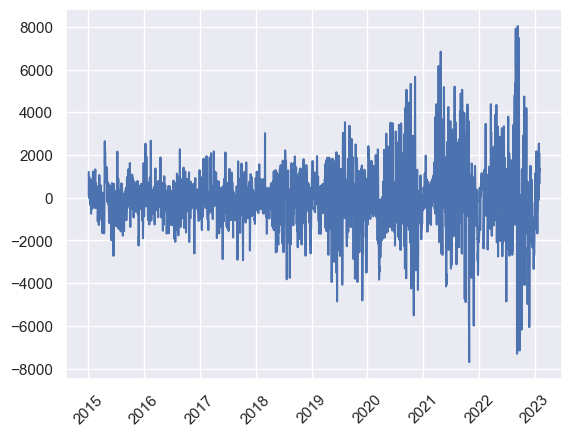

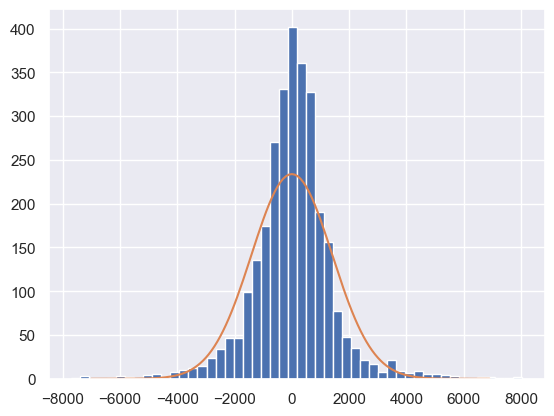

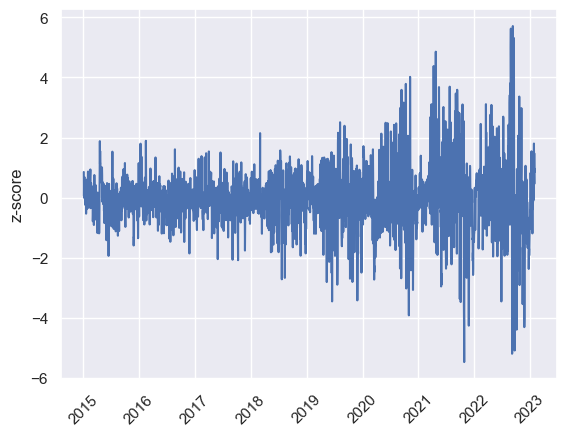

DATE
2020-11-07    4.017886
2021-04-10    4.376933
2021-04-24    4.855374
2022-08-27    5.003152
2022-08-28    5.622686
2022-09-03    4.736143
2022-09-04    5.171598
2022-09-09    4.624548
2022-09-10    5.707515
2022-09-17    5.308927
dtype: float64
DATE
2021-10-26   -4.244747
2021-10-27   -5.467133
2021-11-26   -4.255764
2022-09-05   -5.190681
2022-09-06   -5.159809
2022-09-22   -5.082630
2022-10-05   -4.388633
2022-11-24   -4.305339
dtype: float64


In [123]:
# All data
residuals = features['count'] - ewma_model.predict(features)
plt.plot(residuals)
plt.xticks(rotation=45);
plt.show()

residuals.hist(bins=50)
x = np.arange(-7000, 7000, 100)
dist = stats.norm(scale=residuals.std())
plt.plot(x, dist.pdf(x) * 14000 / 50. * len(residuals));
plt.show()

z = residuals / residuals.std()
plt.plot(z)
plt.ylabel('z-score')
plt.xticks(rotation=45);
plt.show()

threshold = 4.0
outliers_high = z[z > threshold]
outliers_low = z[z < -threshold]
print(outliers_high)
print(outliers_low)

In [124]:
# Calculate rolling averages for evaluating outliers
def get_rolling_avgs(df, columns, window=14):
    df_new = df.copy()
    for column in columns:
        df_new[column + '_rolling'] = df_new[column].rolling(window, center=True).mean().fillna(method='pad')
    return df_new

columns = ['count', 'AWND', 'PRCP', 'SNOW', 'TAVG']

features_rolling = get_rolling_avgs(features, columns, window=7)

Let's start by looking at the case where there were significantly more riders than the model expected.

In [125]:
more_than_expected = features_rolling.merge(pd.DataFrame(outliers_high, columns=['z-score']), 
                                    on='DATE', how='inner')
print(more_than_expected)

            count   AWND  PRCP  SNOW  TAVG  count_rolling  AWND_rolling  \
DATE                                                                      
2020-11-07  12248   7.61   0.0   0.0    61    8301.428571      8.595714   
2021-04-10  12517   9.84   0.0   0.0    59    7090.857143     10.288571   
2021-04-24  13839  12.30   0.0   0.0    61    7067.714286     13.997143   
2022-08-27  21555   9.40   0.0   0.0    72   19718.857143      9.461429   
2022-08-28  21985   9.40   0.0   0.0    71   19872.857143     10.132857   
2022-09-03  23253  10.29   0.0   0.0    66   18832.714286      9.874286   
2022-09-04  24054   8.95   0.0   0.0    71   19120.571429      9.970000   
2022-09-09  25231   5.59   0.0   0.0    65   21282.142857      8.115714   
2022-09-10  26461   6.49   0.0   0.0    72   22570.857143      7.635714   
2022-09-17  26725   9.62   0.0   0.0    61   22553.000000     11.057143   

            PRCP_rolling  SNOW_rolling  TAVG_rolling   z-score  
DATE                              

The anomalies in Aug and Sept 2022 are most likely explained by a free pass program offered by the city from 2022-08-19 to 2022-09-19 due to a MBTA Orange Line shutdown. Easier access to Bluebikes likely led to more ridership demand.

As for the other anomalies, comparing the temperatures on those days to the rolling averages indicates they were unseasonably warm days, likely enticing more people to ride.

Next let's look at the opposite case; where there were significantly less riders than the model expected.

In [126]:
less_than_expected = features_rolling.merge(pd.DataFrame(outliers_low, columns=['z-score']), 
                                    on='DATE', how='inner')
print(less_than_expected)

            count   AWND  PRCP  SNOW  TAVG  count_rolling  AWND_rolling  \
DATE                                                                      
2021-10-26   5445  23.04  0.92   0.0    57    9804.571429     14.828571   
2021-10-27   4766  26.62  0.10   0.0    51    8373.000000     15.595714   
2021-11-26   2832  12.53  0.04   0.0    45    4550.142857     11.984286   
2022-09-05   9624   8.50  0.44   0.0    70   19267.142857      9.618571   
2022-09-06   9797  10.29  0.53   0.0    64   19659.285714      9.107143   
2022-09-22  12279  12.30  0.75   0.0    65   16945.571429     11.151429   
2022-10-05   9952  13.20  0.44   0.0    56   13812.285714     14.605714   
2022-11-24   3597   7.38  0.00   0.0    39    5508.000000     10.960000   

            PRCP_rolling  SNOW_rolling  TAVG_rolling   z-score  
DATE                                                            
2021-10-26      0.261429           0.0     51.428571 -4.244747  
2021-10-27      0.407143           0.0     51.285714 -

For several of the detected anomalies, there was significant rainfall which likely detered many riders from cycling that day. For 2021-10-26 and 2021-10-27, the wind speed was noticeably higher than the rolling average, creating unfavorable biking conditions. Lastly 2022-11-24 and 2021-11-26 were Thanksgiving holidays, likely resulting in many people being out of town. 

Out of curiosity, let's run the same z-score analysis just on the training and validation sets to see if different anomalous days appear.

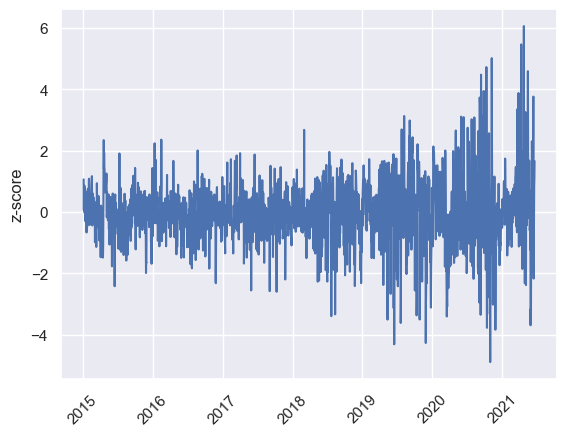

DATE
2020-09-12    4.480227
2020-10-10    4.727636
2020-11-07    5.019102
2021-04-10    5.467619
2021-04-24    6.065283
2021-05-15    4.594702
dtype: float64
DATE
2019-06-16   -4.309315
2019-11-28   -4.266688
2020-10-30   -4.888676
dtype: float64


In [127]:
# Training data
residuals = train['count'] - ewma_model.predict(train)
z = residuals / residuals.std()
plt.plot(z)
plt.ylabel('z-score')
plt.xticks(rotation=45);
plt.show()

threshold = 4.0
outliers_high = z[z > threshold]
outliers_low = z[z < -threshold]
print(outliers_high)
print(outliers_low)

In [128]:
more_than_expected = features_rolling.merge(pd.DataFrame(outliers_high, columns=['z-score']), 
                                    on='DATE', how='inner')
print(more_than_expected)

less_than_expected = features_rolling.merge(pd.DataFrame(outliers_low, columns=['z-score']), 
                                    on='DATE', how='inner')
print(less_than_expected)

            count   AWND  PRCP  SNOW  TAVG  count_rolling  AWND_rolling  \
DATE                                                                      
2020-09-12  14401   9.62   0.0   0.0    60   10232.428571      8.948571   
2020-10-10  14267  19.46   0.0   0.0    63    8402.142857     15.114286   
2020-11-07  12248   7.61   0.0   0.0    61    8301.428571      8.595714   
2021-04-10  12517   9.84   0.0   0.0    59    7090.857143     10.288571   
2021-04-24  13839  12.30   0.0   0.0    61    7067.714286     13.997143   
2021-05-15  13935   8.95   0.0   0.0    67   10403.142857      8.787143   

            PRCP_rolling  SNOW_rolling  TAVG_rolling   z-score  
DATE                                                            
2020-09-12      0.035714           0.0     65.571429  4.480227  
2020-10-10      0.217143           0.0     57.142857  4.727636  
2020-11-07      0.000000           0.0     55.428571  5.019102  
2021-04-10      0.000000           0.0     52.000000  5.467619  
2021-04-2

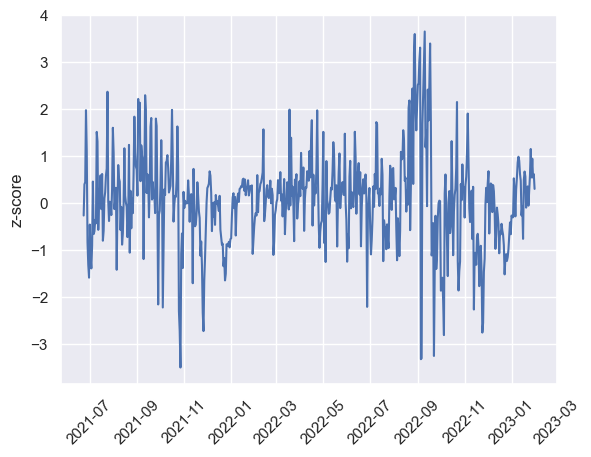

DATE
2022-08-27    3.203914
2022-08-28    3.600651
2022-09-04    3.311784
2022-09-10    3.654974
2022-09-17    3.399726
dtype: float64
DATE
2021-10-27   -3.501038
2022-09-05   -3.324004
2022-09-06   -3.304234
2022-09-22   -3.254810
dtype: float64


In [129]:
# Validation data
residuals = valid['count'] - ewma_model.predict(valid)
z = residuals / residuals.std()
plt.plot(z)
plt.ylabel('z-score')
plt.xticks(rotation=45);
plt.show()

threshold = 3.1
outliers_high = z[z > threshold]
outliers_low = z[z < -threshold]
print(outliers_high)
print(outliers_low)

In [130]:
more_than_expected = features_rolling.merge(pd.DataFrame(outliers_high, columns=['z-score']), 
                                    on='DATE', how='inner')
print(more_than_expected)

less_than_expected = features_rolling.merge(pd.DataFrame(outliers_low, columns=['z-score']), 
                                    on='DATE', how='inner')
print(less_than_expected)

            count  AWND  PRCP  SNOW  TAVG  count_rolling  AWND_rolling  \
DATE                                                                     
2022-08-27  21555  9.40   0.0   0.0    72   19718.857143      9.461429   
2022-08-28  21985  9.40   0.0   0.0    71   19872.857143     10.132857   
2022-09-04  24054  8.95   0.0   0.0    71   19120.571429      9.970000   
2022-09-10  26461  6.49   0.0   0.0    72   22570.857143      7.635714   
2022-09-17  26725  9.62   0.0   0.0    61   22553.000000     11.057143   

            PRCP_rolling  SNOW_rolling  TAVG_rolling   z-score  
DATE                                                            
2022-08-27      0.058571           0.0     74.857143  3.203914  
2022-08-28      0.105714           0.0     75.571429  3.600651  
2022-09-04      0.138571           0.0     67.857143  3.311784  
2022-09-10      0.021429           0.0     68.714286  3.654974  
2022-09-17      0.062857           0.0     65.571429  3.399726  
            count   AWND  